In [1]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
np.seterr(divide = 'ignore')

path = Path(os.getcwd()).parent

def sample(softmax, temperature):

    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax) + EPSILON).astype('float64')
    
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)

    return probas[0]

def remove(preds, max_drop, temperature):
    
    to_drop = len(preds)*[0]
    for _ in range(max_drop):
        to_drop += (sample(preds, temperature))
        
    return to_drop

def plots(score, temperature):
    
    labels = [s[0] for s in score]
    preds = [s[1] for s in score]

    ks = [stats.ks_2samp(l, p) for l,p in zip(labels, preds)]
    auc = [metrics.roc_auc_score(l, p) for l,p in zip(labels, preds)]

    plt.plot(auc)
    plt.plot(len(auc)*[0.5])
    plt.xlabel("number of iterations")
    plt.ylabel('auc')
    plt.grid()
    plt.title(temperature)
    plt.show()
    
    plt.plot([k[0] for k in ks])
    plt.ylabel('ks-stats')
    plt.xlabel('number of iterations')
    plt.grid()
    plt.show()
    
    plt.plot([k[1] for k in ks], linewidth=2.0)
    plt.ylabel('p-value')
    plt.xlabel('number of iterations')
    plt.grid()
    plt.show()


## Attribute Comparison

Each row is labelled with its (survey) *source*.

- *Source*
- Geschlecht
- Alter
- Schulabschluss 
- Berufsgruppe
- Erwerbstätigkeit
- wöchentliche Arbeitszeit
- Berufsgruppe 
- BRS1, BRS2, BRS3, BRS4, BRS5, BRS6
- Optimismus
- Pessimismus 
- ASKU1, ASKU2, ASKU3
- IE_int1
- IE_int2 
- IE_ext1
- IE_ext2

### Preprocessing: Allensbach

In [2]:
allensbach_cols = ['S01', 'S02', 'S03_rec', 'S04_rec', 'S05',
                   'V04_01', 'V04_02', 'V04_03', 'V04_04', 'V04_05', 'V04_06',
                   'S06b_rec', 'V01', 'V22',
                   'V20_5', 'V20_6', 'V20_7',
                   'V20_1', 'V20_2', 'V20_3', 'V20_4']

names = ['Geschlecht', 'Alter', 'Schulabschluss', 'Berufsgruppe', 'Erwerbstätigkeit',
         'BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6',
         'woechentlicheArbeitszeit', 'Optimismus', 'Pessimismus',
         'ASKU1', 'ASKU2', 'ASKU3',
         'IE_int1', 'IE_int2', 'IE_ext1', 'IE_ext2']

allensbach = pd.read_csv(os.path.join(path, 'data/Allensbach/abs_data.csv'),
                         usecols = allensbach_cols,
                         delimiter=';', low_memory=False)

allensbach.replace(',', '.', regex=True, inplace=True)
allensbach.replace(' ', np.nan, regex=True, inplace=True)

allensbach.rename(columns= dict(zip(allensbach_cols, names)), inplace=True)

allensbach.head()

,Geschlecht,Alter,Erwerbstätigkeit,Optimismus,BRS1,BRS2,BRS3,BRS4,BRS5,BRS6,...,IE_int2,IE_ext1,IE_ext2,ASKU1,ASKU2,ASKU3,Pessimismus,Schulabschluss,Berufsgruppe,woechentlicheArbeitszeit
0,2,73,2,7,5,4,1,4,4,5,...,1,5,4,1,1,1,1,2,8,NaN
1,2,24,NaN,5,2,4,2,5,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,51,1,2,2,4,NaN,5,1,5,...,2,NaN,4,2,2,3,6,3,3,4
3,1,57,1,6,5,3,5,3,5,3,...,2,4,5,1,2,1,2,5,2,3
4,1,64,2,4,4,4,4,4,4,4,...,3,2,2,5,1,1,4,2,1,NaN


### Preprocessing: GBS

In [3]:
gbs1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs1.csv'))
gbs2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs2.csv'))

mapping1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map1.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')
mapping2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map2.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')

# Rename 'GBS-CODE' column
key = 'GBS-CODE'
mapping1 = mapping1.rename(columns={'GBS Code': key})
mapping2 = mapping2.rename(columns={'GBS Code': key})
gbs1 = gbs1.rename(columns={'gbs_code': key})
gbs2 = gbs2.rename(columns={'GBS-Code': key})

# Merge GBS "Umfrage Wellen" and create dataframe
gbs = pd.merge(gbs1, gbs2, how='inner', on=key)
gbs = pd.merge(gbs, mapping1, how='left', on=key)
gbs = pd.merge(gbs, mapping2, how='left', on=key)

gbs_cols = ['am01', 'am02_02', 'am14', 'am22', 'am17',
           'br01_01', 'br01_02', 'br01_03', 'br01_04', 'br01_05', 'br01_06',
           'am20_01', 'so01_01', 'so02_01',
           'sw02_01', 'sw02_02', 'sw02_03',
           'ie01_01', 'ie01_02', 'ie01_03', 'ie01_04']+[key]

names = ['Geschlecht', 'Alter', 'Schulabschluss', 'Berufsgruppe', 'Erwerbstätigkeit',
         'BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6',
         'woechentlicheArbeitszeit', 'Optimismus', 'Pessimismus',
         'ASKU1', 'ASKU2', 'ASKU3',
         'IE_int1', 'IE_int2', 'IE_ext1', 'IE_ext2']

gbs = gbs[gbs_cols]
gbs.rename(columns= dict(zip(gbs_cols, names+['Id'])), inplace=True)

del mapping1, mapping2, gbs1, gbs2

gbs.sort_values('Id', ascending=1, inplace=True)

twice = []
for i in range(len(gbs.Id)-1):
    if gbs.iloc[[i]].values[0][-1] == gbs.iloc[[i+1]].values[0][-1]:
        #print(gbs.iloc[[i]].values[0][-1], gbs.iloc[[i+1]].values[0][-1])
        twice.append(gbs.iloc[[i]].index)
gbs = gbs[~gbs['Id'].isin(twice)]
        
gbs = gbs.iloc[::2, :]

### VALUE MAPPING

In [4]:
di1 = {'männlich': 1, "Männlich": 1, 'weiblich': 2, "Weiblich": 2, '[NA] Keine Angabe':np.nan}
gbs.replace({"Geschlecht": di1}, inplace=True)

di2 = {'Hochschulabschluss':5, 
       'Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)': 4, 
       'Fachhochschulreife (Abschluss einer Fachoberschule)': 4, 
       'Realschulabschluss (Mittlere Reife)': 3,
       'Hauptschulabschluss/Volksschulabschluss': 2,
       'Abschluss Polytechnische Oberschule 10. Klasse (vor 1965: 8. Klasse)': 1, 
       'Anderer Schulabschluss:': 1}
gbs.replace({'Schulabschluss': di2}, inplace=True)

di3 = {
    'Selbstständige(r) Landwirt/-in bzw. Genossenschaftsbauer/-bäuerin':8,
    'Selbstständige (im Handel, im Gastgewerbe, im Handwerk, in der Industrie, der Dienstleistung, auch Ich-AG oder Produktionsgenossenschaft des Handwerks (PGH)-Mitglied)':5,
    'Angestellte(r)':3,
    'Beamter/Beamtin, Richter/-in, Berufssoldat/-in':4,
    'Akademiker/-in in freiem Beruf (Arzt/Ärztin, Rechtsanwalt/-anwältin, Steuerberater/-in u. Ä.)':2,
    '[NA] Keine Angabe':8,
    'keine passende Angabe':8,
    'Ausbildung':8,
    'Arbeiter/-in':3,
    'mithelfende(r) Familienangehörige(r)':1
}
gbs.replace({'Berufsgruppe':di3}, inplace=True)

arbeitszeit = []
for w in gbs.woechentlicheArbeitszeit:
    if w < 20:
        arbeitszeit.append(1)
    elif w >= 20 and w < 30:
        arbeitszeit.append(2)
    elif w >= 30 and w <= 40:
        arbeitszeit.append(3)
    elif w > 40 and w < 50:
        arbeitszeit.append(4)
    else:
        arbeitszeit.append(5)
gbs['woechentlicheArbeitszeit'] = arbeitszeit

di4 = {9:2,
       999:2,
      -3:2,
      -1:2,
      3:2}
allensbach.replace({'Erwerbstätigkeit': di4}, inplace=True)
gbs.replace({'Erwerbstätigkeit':di4}, inplace=True)

gbs.head()

,Geschlecht,Alter,Schulabschluss,Berufsgruppe,Erwerbstätigkeit,BRS1,BRS2,BRS3,BRS4,BRS5,...,Optimismus,Pessimismus,ASKU1,ASKU2,ASKU3,IE_int1,IE_int2,IE_ext1,IE_ext2,Id
454,1.0,48.0,3.0,4.0,1.0,3.0,2.0,3.0,3.0,3.0,...,3.0,4.0,3.0,3.0,2.0,3.0,3.0,4.0,4.0,GBS+00027
440,2.0,68.0,5.0,8.0,1.0,5.0,1.0,5.0,1.0,5.0,...,7.0,1.0,4.0,4.0,4.0,5.0,5.0,2.0,1.0,GBS+00032
751,2.0,56.0,3.0,4.0,1.0,4.0,4.0,2.0,4.0,2.0,...,4.0,4.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,GBS+00071
910,2.0,55.0,4.0,3.0,1.0,4.0,2.0,4.0,3.0,4.0,...,5.0,2.0,3.0,3.0,3.0,4.0,4.0,2.0,2.0,GBS+00084
307,2.0,60.0,5.0,NaN,NaN,5.0,2.0,5.0,2.0,5.0,...,6.0,2.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0,GBS+00092


In [5]:
allensbach = allensbach.fillna(allensbach.median())
gbs = gbs.fillna(gbs.median())

#for i in names:
#    print(gbs[i].value_counts()) 
#    print(allensbach[i].value_counts())
#    print('#####################')

gbs['label'] = 1
allensbach['label'] = 0

data = pd.concat([gbs, allensbach], sort=True).copy(deep=True)

drop = ['ASKU1', 'ASKU2', 'ASKU3']
data.drop(columns=drop, axis=1, inplace=True)

cols = list(data.columns) 
meta = ['label', 'Id']
for m in meta:
    if m in cols:
        cols.remove(m)

data.head()

,Alter,BRS1,BRS2,BRS3,BRS4,BRS5,BRS6,Berufsgruppe,Erwerbstätigkeit,Geschlecht,IE_ext1,IE_ext2,IE_int1,IE_int2,Id,Optimismus,Pessimismus,Schulabschluss,label,woechentlicheArbeitszeit
454,48,3,2,3,3,3,4,4,1,1.0,4,4,3,3,GBS+00027,3,4,3,1,4
440,68,5,1,5,1,5,1,8,1,2.0,2,1,5,5,GBS+00032,7,1,5,1,1
751,56,4,4,2,4,2,4,4,1,2.0,3,3,3,3,GBS+00071,4,4,3,1,3
910,55,4,2,4,3,4,2,3,1,2.0,2,2,4,4,GBS+00084,5,2,4,1,3
307,60,5,2,5,2,5,2,3,1,2.0,2,2,4,4,GBS+00092,6,2,5,1,5


In [6]:
data_base = data.copy(deep=True)

###################################
(GBS 498 Allensbach 1118), (GBS 490 Allensbach 1108), (GBS 482 Allensbach 1098), (GBS 477 Allensbach 1086), (GBS 468 Allensbach 1076), (GBS 461 Allensbach 1064), (GBS 457 Allensbach 1051), (GBS 454 Allensbach 1038), (GBS 448 Allensbach 1026), (GBS 442 Allensbach 1014), (GBS 437 Allensbach 999), (GBS 431 Allensbach 986), (GBS 426 Allensbach 973), (GBS 420 Allensbach 959), (GBS 412 Allensbach 947), (GBS 406 Allensbach 933), (GBS 401 Allensbach 922), (GBS 395 Allensbach 909), (GBS 392 Allensbach 894), (GBS 386 Allensbach 884), (GBS 378 Allensbach 874), (GBS 376 Allensbach 859), (GBS 371 Allensbach 845), (GBS 364 Allensbach 834), (GBS 362 Allensbach 818), (GBS 355 Allensbach 808), (GBS 347 Allensbach 797), (GBS 341 Allensbach 785), (GBS 334 Allensbach 774), (GBS 331 Allensbach 760), (GBS 326 Allensbach 751), (GBS 319 Allensbach 740), (GBS 312 Allensbach 730), (GBS 306 Allensbach 718), (GBS 302 Allensbach 705), (GBS 299 Allensbach 689), (GBS 293 Allensbac

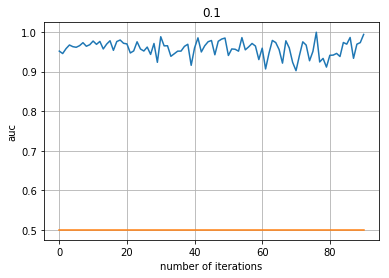

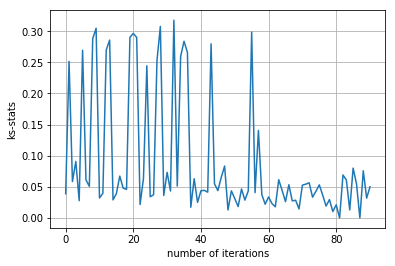

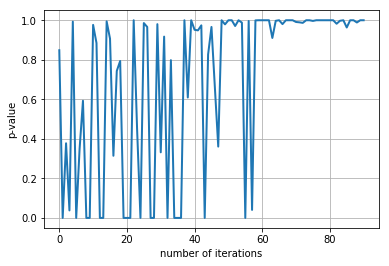

###################################
(GBS 496 Allensbach 1118), (GBS 490 Allensbach 1105), (GBS 484 Allensbach 1093), (GBS 480 Allensbach 1078), (GBS 477 Allensbach 1062), (GBS 471 Allensbach 1049), (GBS 469 Allensbach 1034), (GBS 463 Allensbach 1020), (GBS 455 Allensbach 1010), (GBS 450 Allensbach 996), (GBS 442 Allensbach 984), (GBS 436 Allensbach 970), (GBS 429 Allensbach 957), (GBS 425 Allensbach 941), (GBS 419 Allensbach 928), (GBS 412 Allensbach 916), (GBS 406 Allensbach 902), (GBS 402 Allensbach 887), (GBS 399 Allensbach 872), (GBS 393 Allensbach 860), (GBS 386 Allensbach 847), (GBS 380 Allensbach 835), (GBS 374 Allensbach 824), (GBS 367 Allensbach 813), (GBS 364 Allensbach 797), (GBS 360 Allensbach 784), (GBS 356 Allensbach 769), (GBS 354 Allensbach 752), (GBS 351 Allensbach 739), (GBS 348 Allensbach 724), (GBS 341 Allensbach 712), (GBS 337 Allensbach 698), (GBS 332 Allensbach 686), (GBS 324 Allensbach 675), (GBS 316 Allensbach 666), (GBS 308 Allensbach 654), (GBS 302 Allensbach

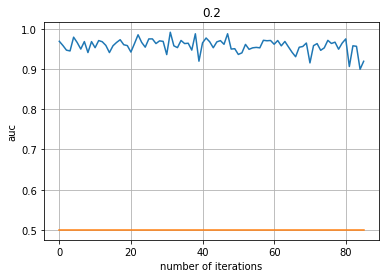

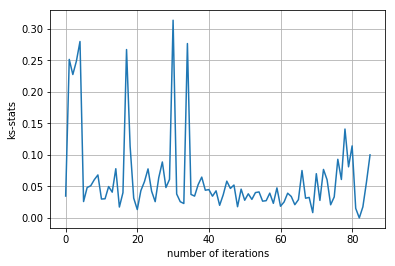

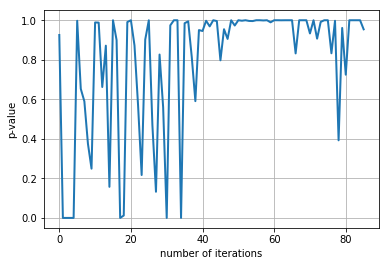

###################################
(GBS 499 Allensbach 1113), (GBS 492 Allensbach 1101), (GBS 486 Allensbach 1088), (GBS 479 Allensbach 1076), (GBS 474 Allensbach 1062), (GBS 469 Allensbach 1050), (GBS 465 Allensbach 1035), (GBS 459 Allensbach 1021), (GBS 450 Allensbach 1010), (GBS 443 Allensbach 997), (GBS 438 Allensbach 984), (GBS 432 Allensbach 973), (GBS 430 Allensbach 958), (GBS 427 Allensbach 942), (GBS 418 Allensbach 931), (GBS 414 Allensbach 917), (GBS 408 Allensbach 904), (GBS 403 Allensbach 890), (GBS 395 Allensbach 879), (GBS 392 Allensbach 864), (GBS 385 Allensbach 852), (GBS 378 Allensbach 840), (GBS 372 Allensbach 827), (GBS 364 Allensbach 816), (GBS 359 Allensbach 801), (GBS 349 Allensbach 792), (GBS 342 Allensbach 781), (GBS 336 Allensbach 769), (GBS 330 Allensbach 756), (GBS 326 Allensbach 741), (GBS 320 Allensbach 728), (GBS 315 Allensbach 715), (GBS 309 Allensbach 703), (GBS 303 Allensbach 690), (GBS 300 Allensbach 674), (GBS 295 Allensbach 662), (GBS 288 Allensbach

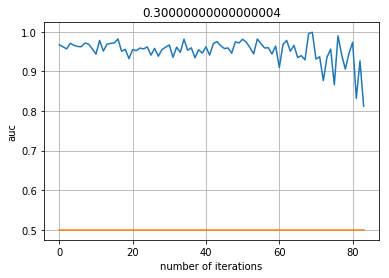

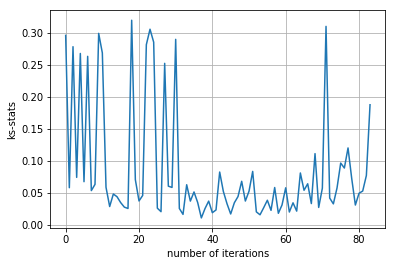

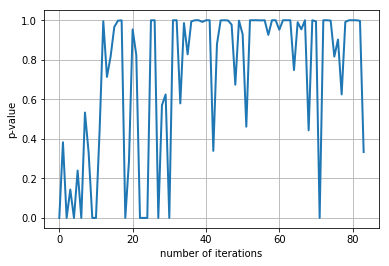

###################################
(GBS 498 Allensbach 1115), (GBS 490 Allensbach 1103), (GBS 483 Allensbach 1090), (GBS 476 Allensbach 1078), (GBS 471 Allensbach 1064), (GBS 464 Allensbach 1053), (GBS 459 Allensbach 1040), (GBS 453 Allensbach 1027), (GBS 448 Allensbach 1012), (GBS 444 Allensbach 996), (GBS 441 Allensbach 981), (GBS 435 Allensbach 968), (GBS 430 Allensbach 953), (GBS 424 Allensbach 939), (GBS 417 Allensbach 929), (GBS 411 Allensbach 917), (GBS 405 Allensbach 903), (GBS 398 Allensbach 891), (GBS 391 Allensbach 878), (GBS 388 Allensbach 863), (GBS 382 Allensbach 849), (GBS 376 Allensbach 836), (GBS 370 Allensbach 822), (GBS 366 Allensbach 808), (GBS 363 Allensbach 793), (GBS 355 Allensbach 784), (GBS 350 Allensbach 769), (GBS 345 Allensbach 754), (GBS 338 Allensbach 741), (GBS 332 Allensbach 729), (GBS 330 Allensbach 711), (GBS 325 Allensbach 697), (GBS 322 Allensbach 682), (GBS 314 Allensbach 671), (GBS 306 Allensbach 660), (GBS 300 Allensbach 647), (GBS 295 Allensbach

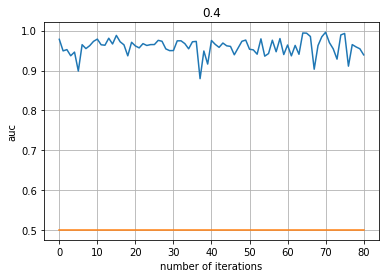

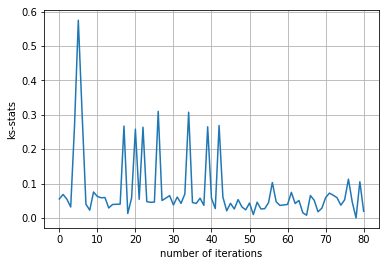

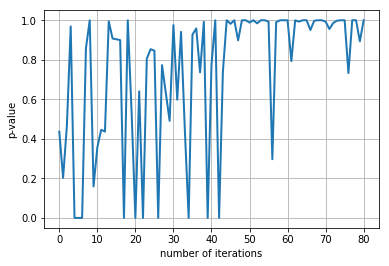

###################################
(GBS 498 Allensbach 1114), (GBS 494 Allensbach 1099), (GBS 487 Allensbach 1088), (GBS 478 Allensbach 1077), (GBS 474 Allensbach 1061), (GBS 467 Allensbach 1048), (GBS 460 Allensbach 1035), (GBS 454 Allensbach 1021), (GBS 448 Allensbach 1008), (GBS 442 Allensbach 994), (GBS 435 Allensbach 985), (GBS 430 Allensbach 972), (GBS 425 Allensbach 957), (GBS 420 Allensbach 943), (GBS 412 Allensbach 931), (GBS 402 Allensbach 923), (GBS 394 Allensbach 913), (GBS 391 Allensbach 897), (GBS 383 Allensbach 886), (GBS 378 Allensbach 871), (GBS 375 Allensbach 855), (GBS 370 Allensbach 841), (GBS 364 Allensbach 827), (GBS 360 Allensbach 811), (GBS 351 Allensbach 802), (GBS 345 Allensbach 789), (GBS 339 Allensbach 776), (GBS 332 Allensbach 763), (GBS 327 Allensbach 750), (GBS 322 Allensbach 736), (GBS 316 Allensbach 723), (GBS 313 Allensbach 706), (GBS 306 Allensbach 693), (GBS 302 Allensbach 678), (GBS 295 Allensbach 666), (GBS 288 Allensbach 654), (GBS 279 Allensbach

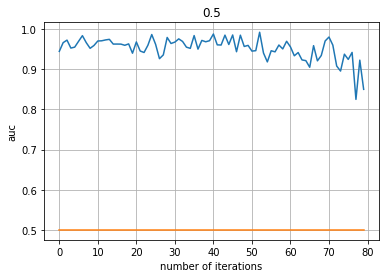

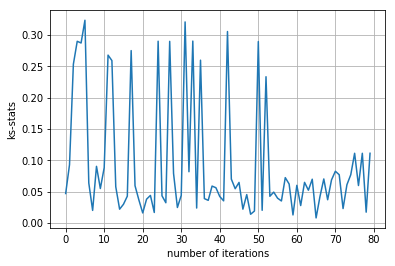

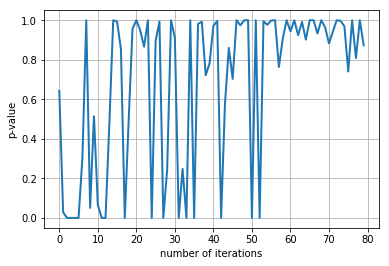

###################################
(GBS 499 Allensbach 1114), (GBS 496 Allensbach 1098), (GBS 491 Allensbach 1083), (GBS 484 Allensbach 1070), (GBS 479 Allensbach 1055), (GBS 472 Allensbach 1042), (GBS 465 Allensbach 1029), (GBS 463 Allensbach 1011), (GBS 456 Allensbach 999), (GBS 449 Allensbach 986), (GBS 447 Allensbach 970), (GBS 441 Allensbach 957), (GBS 435 Allensbach 943), (GBS 431 Allensbach 928), (GBS 425 Allensbach 914), (GBS 420 Allensbach 900), (GBS 413 Allensbach 890), (GBS 407 Allensbach 878), (GBS 402 Allensbach 863), (GBS 400 Allensbach 845), (GBS 394 Allensbach 831), (GBS 388 Allensbach 817), (GBS 384 Allensbach 801), (GBS 376 Allensbach 791), (GBS 368 Allensbach 779), (GBS 361 Allensbach 766), (GBS 355 Allensbach 754), (GBS 348 Allensbach 742), (GBS 340 Allensbach 730), (GBS 335 Allensbach 715), (GBS 330 Allensbach 701), (GBS 324 Allensbach 689), (GBS 317 Allensbach 677), (GBS 314 Allensbach 660), (GBS 310 Allensbach 645), (GBS 303 Allensbach 632), (GBS 296 Allensbach 

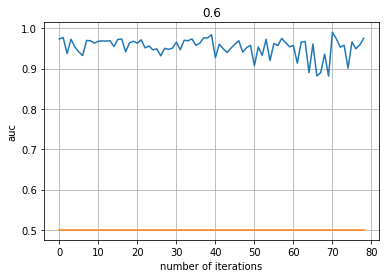

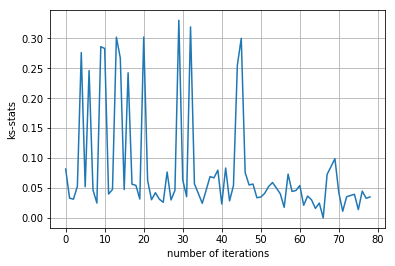

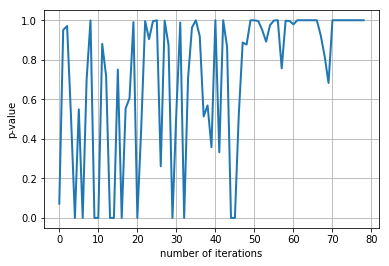

###################################
(GBS 498 Allensbach 1114), (GBS 493 Allensbach 1099), (GBS 485 Allensbach 1087), (GBS 479 Allensbach 1075), (GBS 472 Allensbach 1064), (GBS 465 Allensbach 1052), (GBS 457 Allensbach 1040), (GBS 452 Allensbach 1025), (GBS 447 Allensbach 1011), (GBS 438 Allensbach 1001), (GBS 432 Allensbach 988), (GBS 427 Allensbach 973), (GBS 420 Allensbach 960), (GBS 409 Allensbach 951), (GBS 403 Allensbach 938), (GBS 397 Allensbach 926), (GBS 395 Allensbach 910), (GBS 389 Allensbach 896), (GBS 384 Allensbach 882), (GBS 379 Allensbach 868), (GBS 374 Allensbach 853), (GBS 370 Allensbach 839), (GBS 368 Allensbach 824), (GBS 360 Allensbach 813), (GBS 353 Allensbach 801), (GBS 349 Allensbach 789), (GBS 341 Allensbach 780), (GBS 334 Allensbach 767), (GBS 324 Allensbach 758), (GBS 319 Allensbach 744), (GBS 313 Allensbach 731), (GBS 307 Allensbach 718), (GBS 302 Allensbach 703), (GBS 298 Allensbach 689), (GBS 294 Allensbach 673), (GBS 291 Allensbach 656), (GBS 282 Allensbac

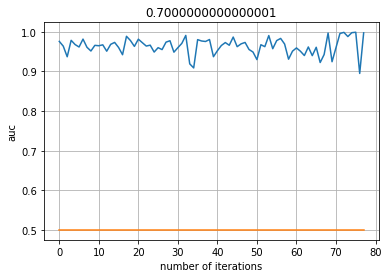

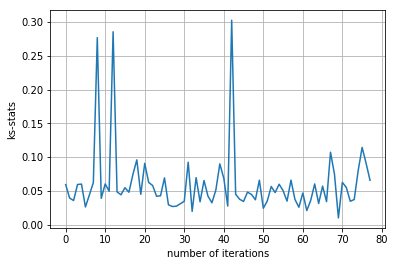

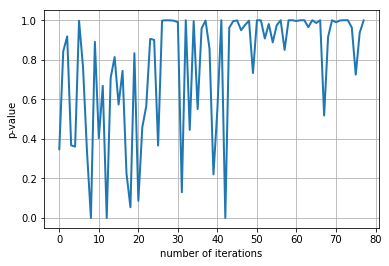

###################################
(GBS 498 Allensbach 1114), (GBS 496 Allensbach 1098), (GBS 489 Allensbach 1086), (GBS 485 Allensbach 1070), (GBS 478 Allensbach 1058), (GBS 473 Allensbach 1044), (GBS 462 Allensbach 1035), (GBS 457 Allensbach 1021), (GBS 450 Allensbach 1008), (GBS 446 Allensbach 993), (GBS 442 Allensbach 977), (GBS 434 Allensbach 965), (GBS 425 Allensbach 954), (GBS 419 Allensbach 941), (GBS 417 Allensbach 923), (GBS 409 Allensbach 911), (GBS 404 Allensbach 897), (GBS 396 Allensbach 885), (GBS 388 Allensbach 873), (GBS 379 Allensbach 862), (GBS 374 Allensbach 847), (GBS 366 Allensbach 836), (GBS 361 Allensbach 822), (GBS 356 Allensbach 808), (GBS 350 Allensbach 795), (GBS 346 Allensbach 781), (GBS 345 Allensbach 764), (GBS 339 Allensbach 753), (GBS 334 Allensbach 739), (GBS 329 Allensbach 725), (GBS 323 Allensbach 711), (GBS 316 Allensbach 698), (GBS 309 Allensbach 685), (GBS 305 Allensbach 669), (GBS 301 Allensbach 653), (GBS 297 Allensbach 640), (GBS 289 Allensbach

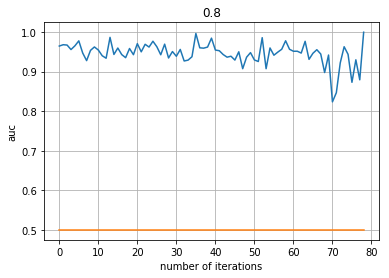

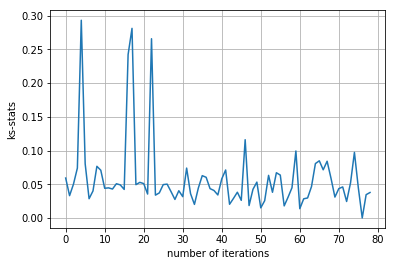

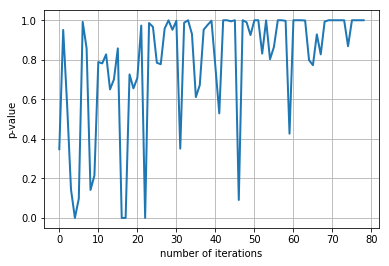

###################################
(GBS 500 Allensbach 1112), (GBS 493 Allensbach 1101), (GBS 488 Allensbach 1086), (GBS 483 Allensbach 1072), (GBS 473 Allensbach 1063), (GBS 469 Allensbach 1047), (GBS 466 Allensbach 1030), (GBS 462 Allensbach 1014), (GBS 457 Allensbach 999), (GBS 448 Allensbach 988), (GBS 442 Allensbach 974), (GBS 435 Allensbach 961), (GBS 423 Allensbach 953), (GBS 417 Allensbach 941), (GBS 413 Allensbach 925), (GBS 404 Allensbach 916), (GBS 398 Allensbach 904), (GBS 390 Allensbach 894), (GBS 383 Allensbach 883), (GBS 377 Allensbach 870), (GBS 371 Allensbach 856), (GBS 365 Allensbach 842), (GBS 356 Allensbach 831), (GBS 354 Allensbach 816), (GBS 351 Allensbach 799), (GBS 344 Allensbach 787), (GBS 342 Allensbach 771), (GBS 339 Allensbach 755), (GBS 332 Allensbach 742), (GBS 327 Allensbach 728), (GBS 324 Allensbach 712), (GBS 317 Allensbach 700), (GBS 309 Allensbach 688), (GBS 302 Allensbach 675), (GBS 296 Allensbach 662), (GBS 293 Allensbach 648), (GBS 287 Allensbach 

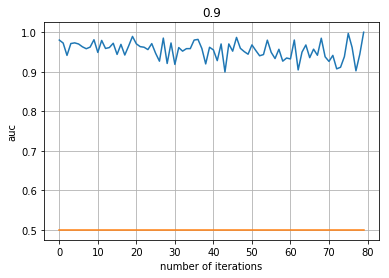

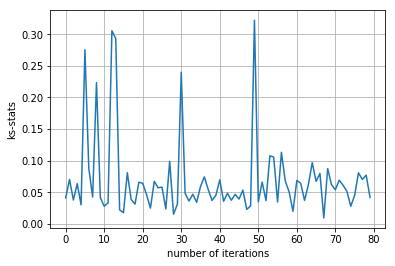

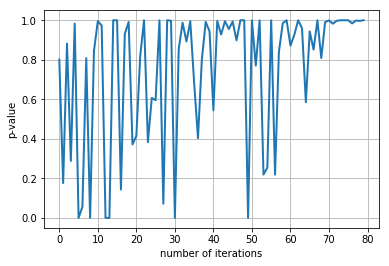

###################################
(GBS 497 Allensbach 1115), (GBS 489 Allensbach 1103), (GBS 487 Allensbach 1085), (GBS 478 Allensbach 1074), (GBS 472 Allensbach 1061), (GBS 465 Allensbach 1048), (GBS 458 Allensbach 1036), (GBS 451 Allensbach 1024), (GBS 445 Allensbach 1010), (GBS 434 Allensbach 1001), (GBS 430 Allensbach 986), (GBS 425 Allensbach 971), (GBS 418 Allensbach 958), (GBS 414 Allensbach 942), (GBS 408 Allensbach 928), (GBS 405 Allensbach 914), (GBS 398 Allensbach 903), (GBS 394 Allensbach 888), (GBS 383 Allensbach 880), (GBS 379 Allensbach 865), (GBS 376 Allensbach 848), (GBS 369 Allensbach 835), (GBS 361 Allensbach 823), (GBS 357 Allensbach 808), (GBS 351 Allensbach 796), (GBS 346 Allensbach 781), (GBS 342 Allensbach 765), (GBS 341 Allensbach 747), (GBS 336 Allensbach 733), (GBS 333 Allensbach 717), (GBS 327 Allensbach 703), (GBS 321 Allensbach 689), (GBS 317 Allensbach 673), (GBS 309 Allensbach 661), (GBS 304 Allensbach 647), (GBS 295 Allensbach 636), (GBS 290 Allensbac

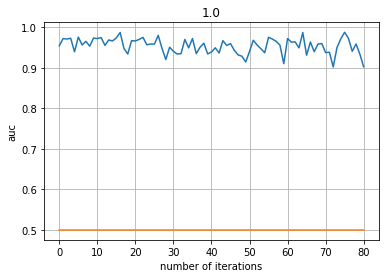

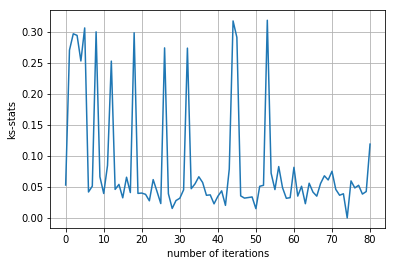

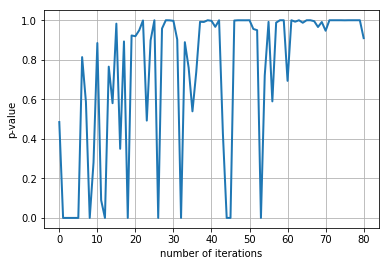

In [7]:
data = data_base.copy(deep=True)

for t in np.arange(0, 1, 0.1):
    
    print('###################################')
    
    temperature = min(0.1 + t, 1) 
    max_drop = 20
    limit = 50
    ensemble_size = 100

    score = []

    while (min(len(data[data.label == 1]), len(data[data.label == 0])) > limit and 
           len(data)>limit):

        nonrep = data[data.label == 1].copy(deep=True)
        rep = data[data.label == 0].copy(deep=True)

        data = pd.concat([nonrep, rep], sort=True)

        train, test = train_test_split(data, test_size=0.3)
        bootstrap = pd.DataFrame(train).sample(len(train), replace=True)
        test = pd.DataFrame(test)

        preds = [0]*len(test)
        for _ in range(ensemble_size):
            
            dt = DecisionTreeClassifier(max_depth=6)
            dt.fit(bootstrap[cols], bootstrap.label)
            
            prob = [p[1] for p in dt.predict_proba(test[cols])]
            preds = [pre + pro for pre, pro in zip(preds, prob)]

        preds = [f/ensemble_size for f in preds]
        
        score.append((test.label, preds))
        
        preds = [random.uniform(0.00001,0.9999999) for p in preds] # override with random guessing.
        
        test['removed'] = remove(preds, max_drop, temperature)
        test = test[test.removed == 0]
        test.drop('removed', axis=1)

        data = pd.concat([train, test], sort=True)
        
        print('(GBS ' + str(len(data[data.label == 1])), 
              'Allensbach ' + str(len(data[data.label == 0]))+')', 
              end=', ')
    
    data = data_base.copy(deep=True)
    plots(score, temperature)